# Generate CIFAR10 Features
In this notebook, we will train an autoencoder to generate features for our MEC RotNet training.

This notebook will:

1. Train an autoencoder on CIFAR10
2. Generate a CSV of CIFAR10 Training Features (from autoencoder in (1)) -> {0/1 Not Rotated/Rotated Label}

In [1]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import tqdm.notebook
import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt

# Set device
DEVICE = torch.device('cuda')

# Set seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

## 1. Train an Autoencoder for CIFAR10

We will build a Convolutional AutoEncoder (CAE) for CIFAR10. This section of the notebook includes 3 parts:
1. Define the Architecture
2. Train the Model on CIFAR10
3. Visualize model predictions 

### 1.1. Create the model

We will adapt a popular CAE architecture seen in many blogposts and tutorials, including [TensorFlow's AutoEncoder tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder#define_a_convolutional_autoencoder).

In [2]:
# Architecture from https://www.tensorflow.org/tutorials/generative/autoencoder#define_a_convolutional_autoencoder
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
                                        nn.Conv2d(3, 16, 3), #Input 3 channel, 16 channel, 3x3 kernel
                                        nn.ReLU(),
                                        nn.Conv2d(16, 8, 3), #Input 3 channel, Output 8 channel, 3x3 kernel
                                        nn.ReLU(),
                                    )
        self.decoder = nn.Sequential(
                                        nn.ConvTranspose2d(8, 8, 3), #Input 8 channel, Output 8 channel, 3x3 kernel
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(8, 16, 3), # Input 8 channel, Output 16 channel
                                        nn.ReLU(),
                                        nn.Conv2d(16, 3, 3, padding=1),
                                        nn.ReLU(),
                                     )
    
    def get_features(self, x):
        encoding, _ = self.forward(x)
        encoding = encoding.detach() #Detach (just in case!)
        encoding = nn.AvgPool2d(28)(encoding) # Global pool -> (B, 8, 1, 1)
        return torch.flatten(encoding, start_dim=1) #(B, 8)
        
    def forward(self, x):
        # x is (B, 1, 28, 28)
        encoding = self.encoder(x) # (B, 8, 28, 28)
        decoding = self.decoder(encoding) # (B, 3, 32, 32)
        assert x.shape == decoding.shape, f"Input {x.shape} but decoding is {decoding.shape}"
        return encoding, decoding

### 1.2 Train the Model

Next, we will train the model for 100 epochs. The model will learn to reconstruct CIFAR10 training images. 

Note: The cell below will download CIFAR10 into "./data/" directory automatically.

In [3]:
# Define Training, Eval
def get_data(path): #Helper function to download data just in case
    _ = CIFAR10(path, train=True) #Download train data
    _ = CIFAR10(path, train=False) #Download val data

def train(model, num_epochs):
    """ Returns trained model, list of training losses (per epoch), list of validation losses (per epoch)"""
    
    # Download data if needed
    get_data("./data/")

    # Get CIFAR dataset
    train_dataset = CIFAR10("./data/", train=True, transform= transforms.ToTensor(), download=False) #Will download if not in ./data/
    dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
    
    model.to(DEVICE)

    # Optimizations
    optimizer = torch.optim.Adam(model.parameters()) #Using default lr = 0.001
    loss_func = nn.MSELoss()

    # Train
    val_losses = []
    training_losses = []
    best_val_loss = None
    for epoch in tqdm.notebook.trange(num_epochs, desc='training', unit='epoch'):
        model.train() #Switch to train, b/c eval turns train off
        epoch_loss = 0.
        with tqdm.notebook.tqdm(dataloader, desc=f'Epoch {epoch}', unit='instance', total=len(dataloader)) as iterator:
            for (i, (img, _)) in enumerate(iterator, start=1):
                img = img.to(DEVICE)

                _, pred_img = model(img)

                loss = loss_func(img, pred_img)
                epoch_loss += loss.item()

                # Update
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Log
                iterator.set_postfix(mean_loss = epoch_loss / i, best_val_loss = best_val_loss)
            # Evaluate
            if best_val_loss is None:
                best_val_loss = float('inf')
            val_loss = evaluate(model)
            best_val_loss = min(val_loss, best_val_loss)

            # Save losses
            training_losses.append(epoch_loss / i)
            val_losses.append(val_loss)
    
    torch.save(model.state_dict, "cifar10_cae.pth.tar")
    print("Model Saved!")
            
    return model, training_losses, val_losses

def evaluate(model):
    """ Returns reconstruction error (MSE) on validation data"""

    # Get CIFAR10 val data
    val_data = CIFAR10("./data/", train=False, transform=transforms.ToTensor(), download=False)
    val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

    # Do not train!
    model.eval()
    with torch.no_grad():
        total_loss = 0.
        for (img, _) in val_dataloader:
            img = img.to(DEVICE)

            _, pred_img = model(img)

            total_loss += nn.MSELoss(reduction='sum')(img, pred_img).item()
    
    return total_loss / len(val_data)



In [4]:
# Create model and train
autoencoder = ConvAutoEncoder()
trained_autoencoder, train_losses, val_losses = train(autoencoder, 100)

training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 0:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 1:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 2:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 3:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 4:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 5:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 6:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 7:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 8:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 9:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 10:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 11:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 12:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 13:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 14:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 15:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 16:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 17:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 18:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 19:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 20:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 21:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 22:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 23:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 24:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 25:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 26:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 27:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 28:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 29:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 30:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 31:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 32:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 33:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 34:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 35:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 36:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 37:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 38:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 39:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 40:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 41:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 42:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 43:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 44:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 45:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 46:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 47:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 48:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 49:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 50:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 51:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 52:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 53:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 54:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 55:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 56:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 57:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 58:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 59:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 60:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 61:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 62:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 63:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 64:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 65:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 66:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 67:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 68:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 69:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 70:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 71:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 72:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 73:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 74:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 75:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 76:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 77:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 78:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 79:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 80:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 81:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 82:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 83:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 84:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 85:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 86:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 87:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 88:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 89:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 90:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 91:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 92:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 93:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 94:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 95:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 96:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 97:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 98:   0%|          | 0/782 [00:00<?, ?instance/s]

Epoch 99:   0%|          | 0/782 [00:00<?, ?instance/s]

Model Saved!


### 1.3 Visualize Predictions (Optional)

Finally, we will visualize some of our model's predictions below!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

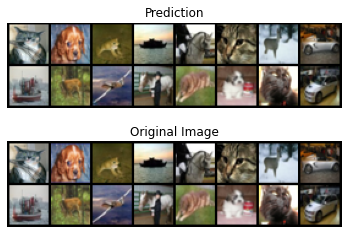

In [5]:
def visualize(model): #Visualize predictions on validation set

    # Get data
    dataset = CIFAR10("./data/", train=False, transform=transforms.ToTensor())
    img_indices = random.sample(range(len(dataset)), 16) #Randomly sample validation images to visualize
    dataset = torch.utils.data.Subset(dataset, img_indices)
    dataloader = DataLoader(dataset, shuffle=False, batch_size=len(dataset), pin_memory=True)

    plt.figure()
    f, axes = plt.subplots(2,1) 

    model.eval()
    with torch.no_grad():
        for (img, _) in dataloader:
            img = img.to(DEVICE)

            _, prediction = model(img)

            axes[0].axis('off')
            axes[1].axis('off')

            axes[0].set_title("Prediction")
            axes[1].set_title("Original Image")

            axes[0].imshow(torchvision.utils.make_grid(prediction).permute(1,2,0).cpu().numpy())
            axes[1].imshow(torchvision.utils.make_grid(img).permute(1,2,0).cpu().numpy())
    return

visualize(trained_autoencoder)
            

## 2. Generate Features

Run the cells below to generate a csv of image features -> rotation label using your trained autoencoder.

In [6]:
class CIFAR10_RotDataset(torch.utils.data.Dataset): #Helper dataset to generate rotated counterparts
    def __init__(self, root="./data/", train=True, transform=None):
        super(CIFAR10_RotDataset, self).__init__()
        self.dataset = CIFAR10(root, train=train, transform=None)
        self.transform = transform
 
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx): # NOTE: Returns original image, rotated image, label
        img, label = self.dataset.__getitem__(idx) #Get original image

        # Make rotated counterpart (rotation angled is randomly sampled)
        rotation_angle = random.randint(1, 3) * 90
        rotated_img = transforms.RandomRotation(rotation_angle)(img)

        if self.transform is not None:
            img = self.transform(img)
            rotated_img = self.transform(rotated_img)

        return img, rotated_img, label

def generate_csv(model, fname, train=True):
    """ Returns CSV of CIFAR10 Features -> Rotation/Not-Rotated"""
    # Get data
    dataset = CIFAR10_RotDataset(train=train, transform=transforms.ToTensor())

    # Eval model
    model.to(DEVICE)
    model.eval()

    # Save data, label
    output = []
    with torch.no_grad():
        for i in tqdm.notebook.trange(len(dataset), desc='Generating Features', unit='Sample'):
            img, rotated_img, label = dataset.__getitem__(i)
            img, rotated_img = img.to(DEVICE), rotated_img.to(DEVICE)

            img_features = model.get_features(img).squeeze().tolist()

            if train:
                rotated_features = model.get_features(rotated_img).squeeze().tolist()
                
                # Add {if Rotated} as label
                img_features.append(0)
                rotated_features.append(1)
                
                output.append(rotated_features)
            
            else: #For validation, we need CIFAR label because we will do regular CIFAR10 classification!
                img_features.append(label)
            
            output.append(img_features)
    
    df = pd.DataFrame(output, columns = [f'Feature {i}' for i in range(1,9)] + ['Label'])
    df.to_csv(fname, index=False)
    
    return


In [7]:
generate_csv(trained_autoencoder, "cifar10_train_data.csv", train=True)
generate_csv(trained_autoencoder, "cifar10_eval_data.csv", train=False)

Generating Features:   0%|          | 0/50000 [00:00<?, ?Sample/s]

Generating Features:   0%|          | 0/10000 [00:00<?, ?Sample/s]